*** Calib Done ***
Calibrate_Camera: Camera Calibration called
mtx: [[  1.15158804e+03   0.00000000e+00   6.66167057e+02]
 [  0.00000000e+00   1.14506859e+03   3.86440204e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
*** Frame Number:  1
Src Points:  [[  576.   460.]
 [  704.   460.]
 [ 1139.   720.]
 [  192.   720.]]
Dst Points:  [[ 320.    0.]
 [ 960.    0.]
 [ 960.  720.]
 [ 320.  720.]]
roc in pixels: 117804.296089 16646.6930266
roc in meters: 38662.7481888 m 5467.06603839 m
*** Frame Number:  2
roc in pixels: 14890.4194084 798182.931563
roc in meters: 4889.18451224 m 261587.571554 m
*** Frame Number:  3
roc in pixels: 2342.69141877 7804.95050889
roc in meters: 768.438874443 m 2504.99091134 m
***Done***


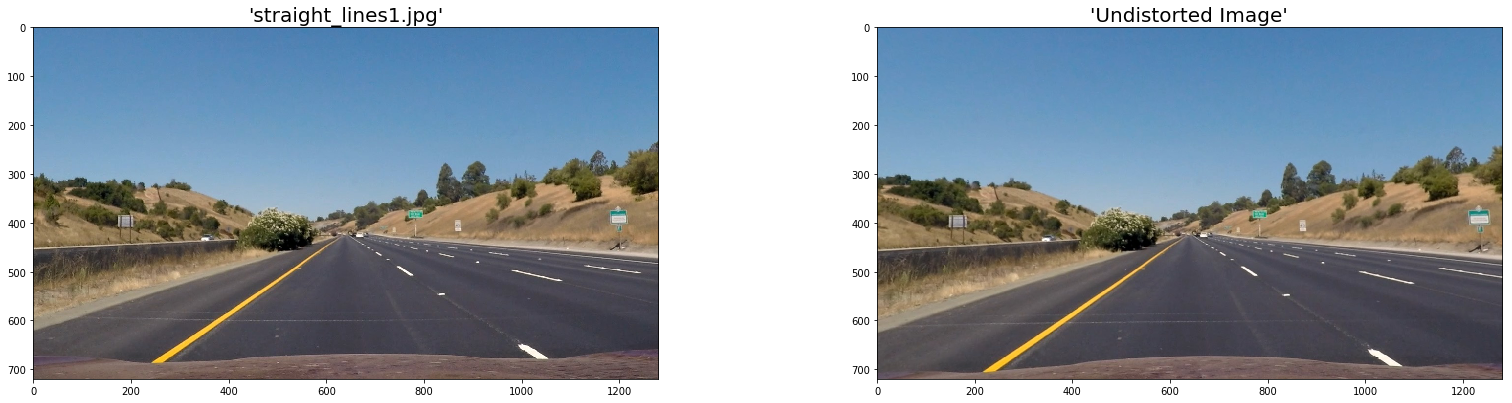

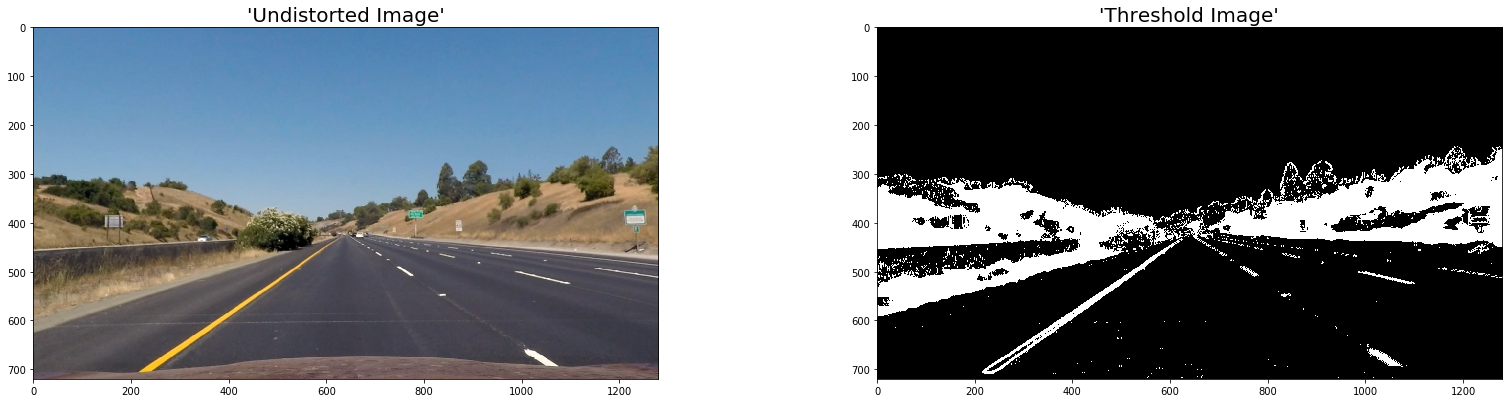

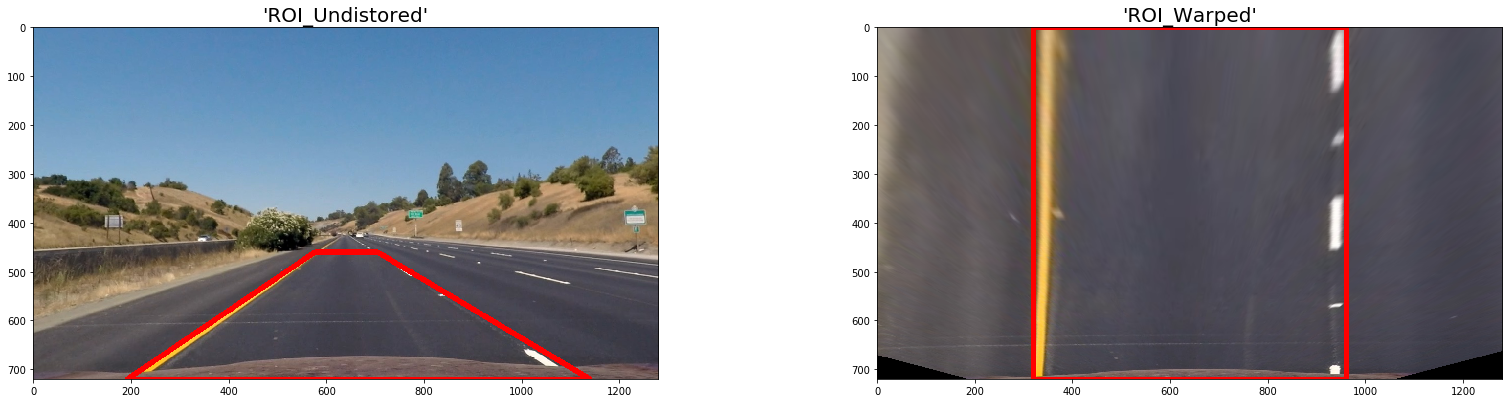

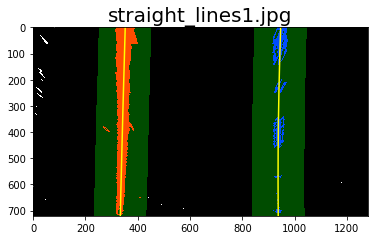

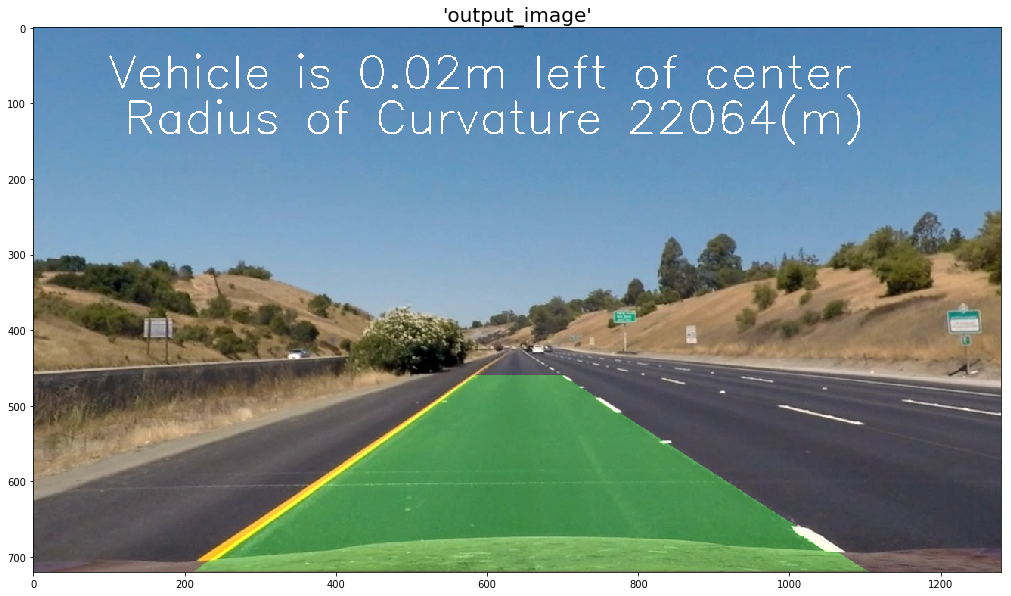

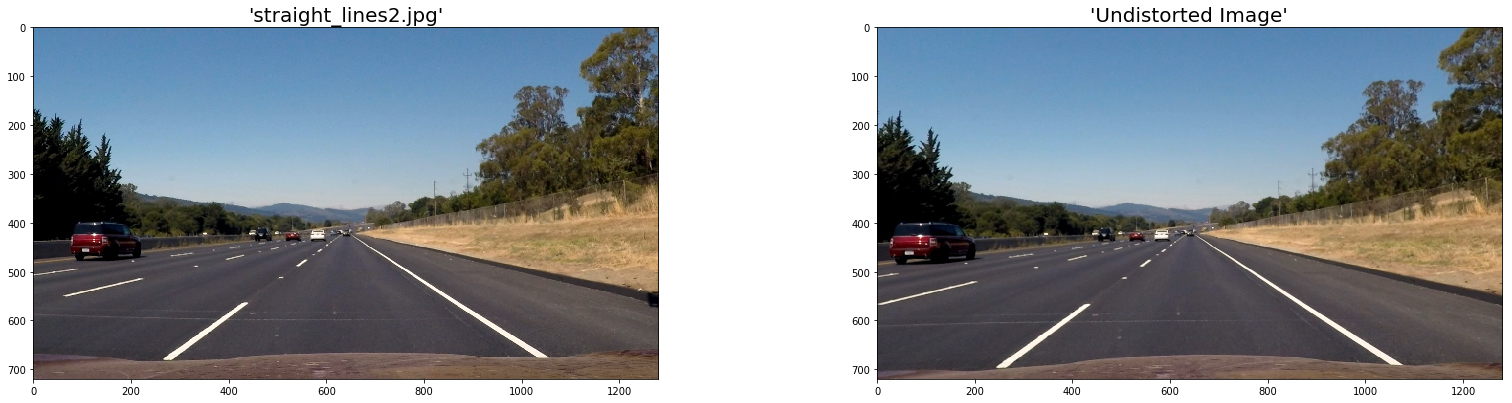

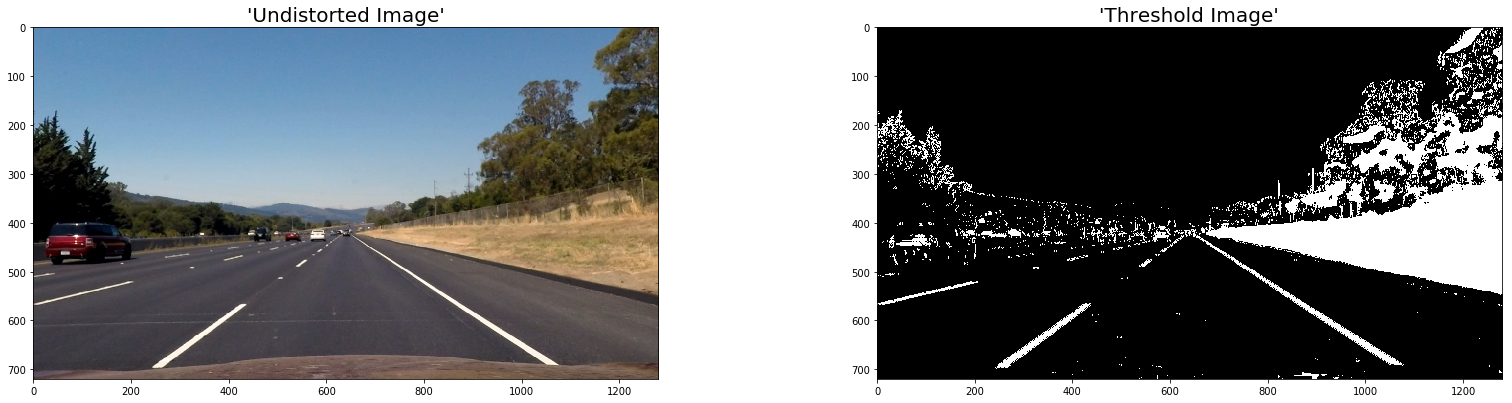

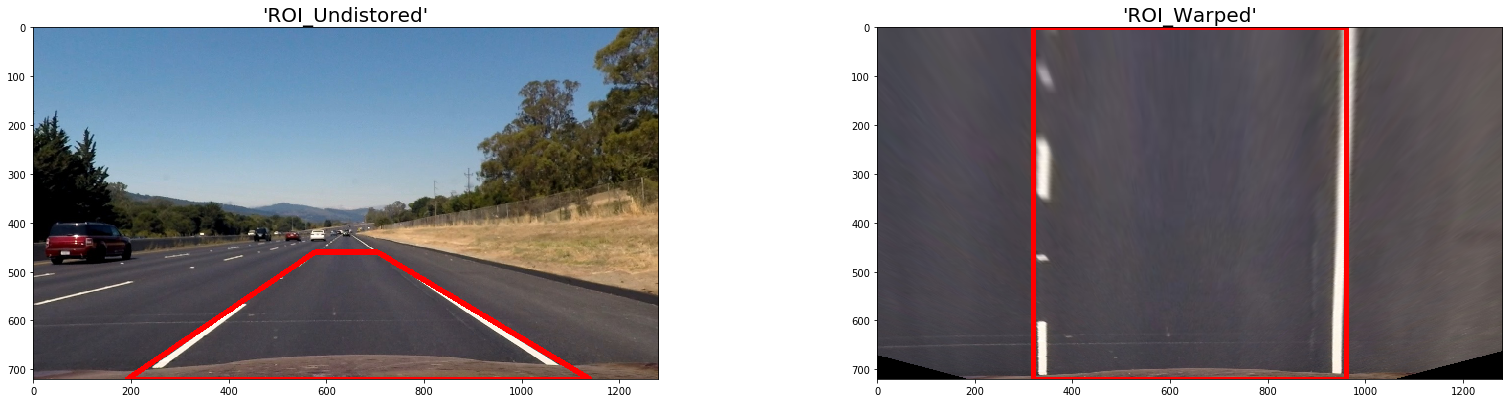

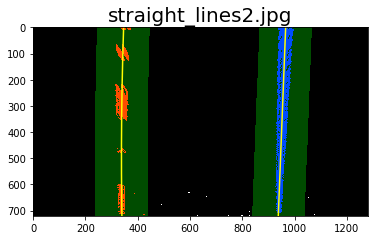

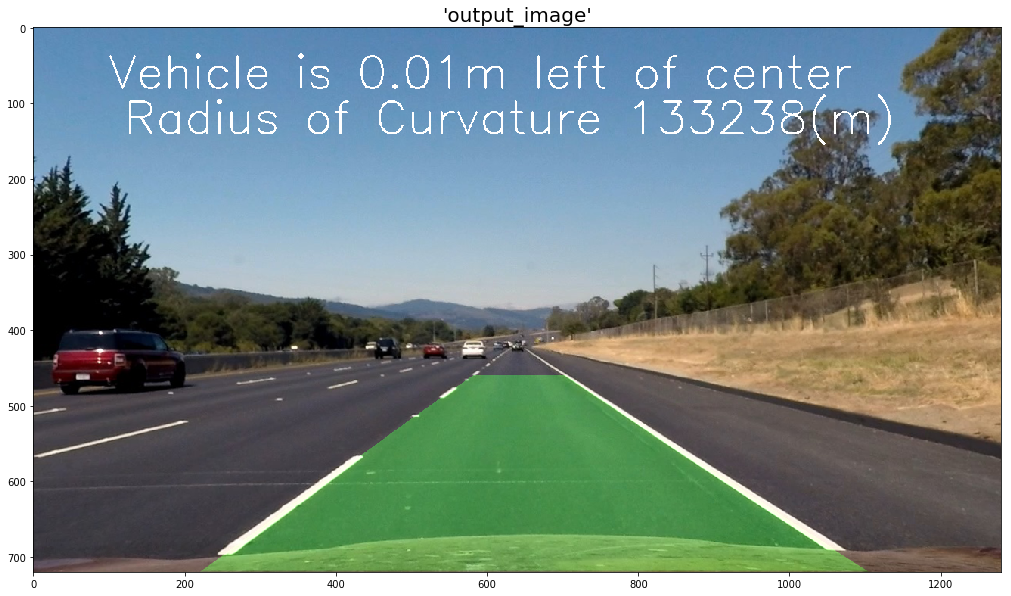

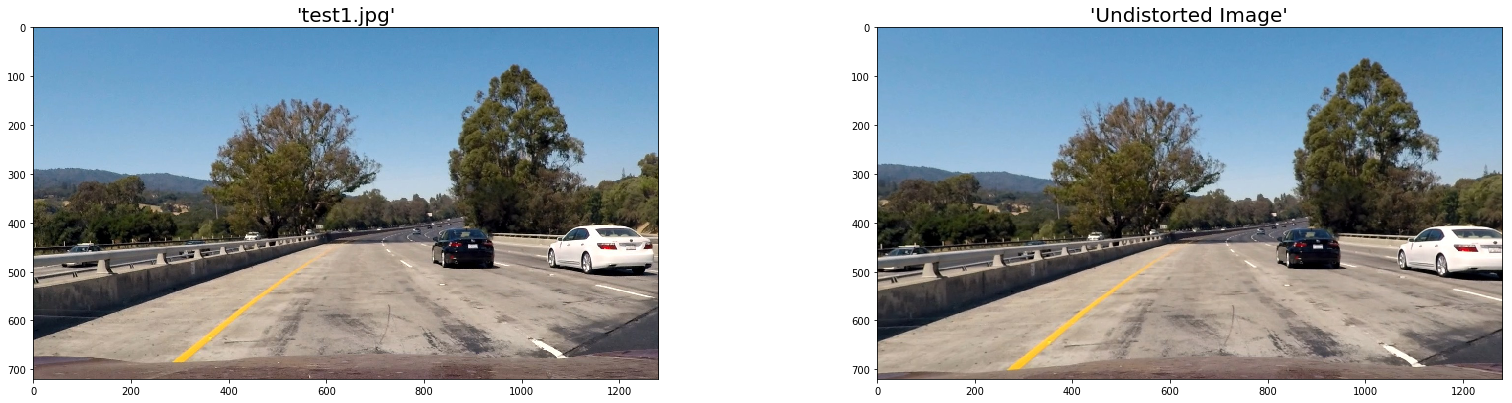

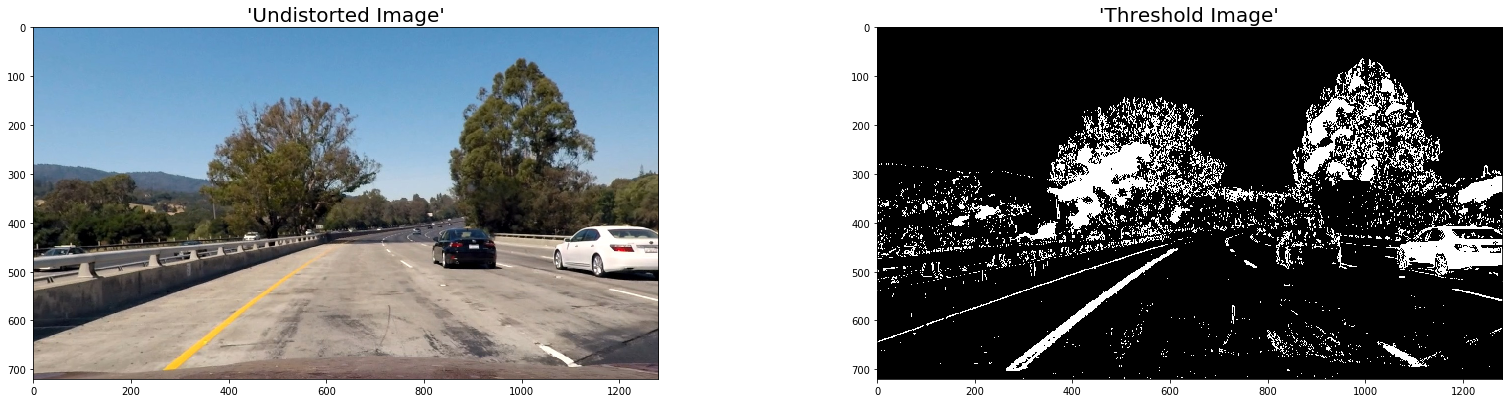

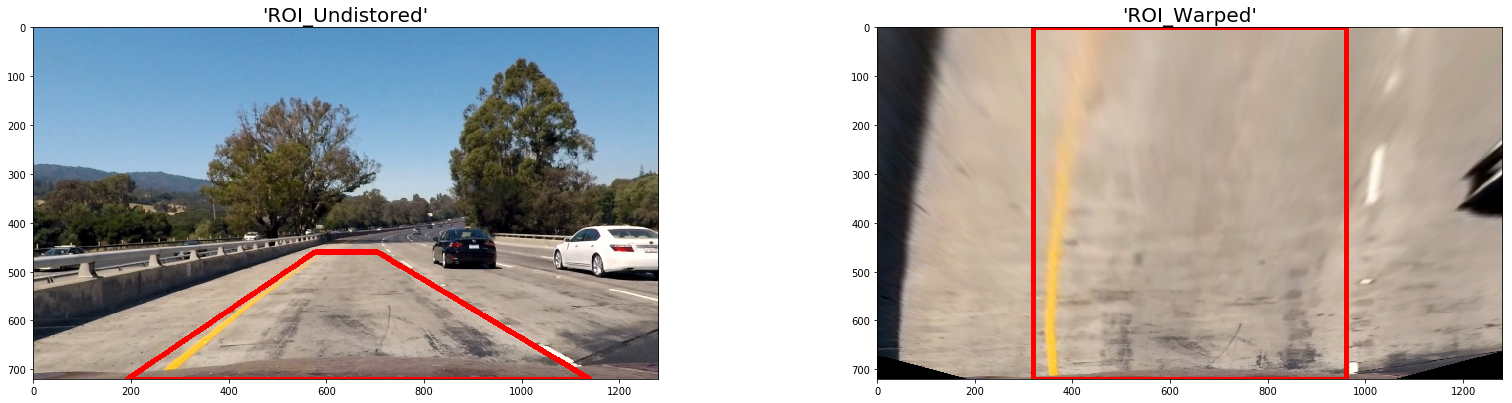

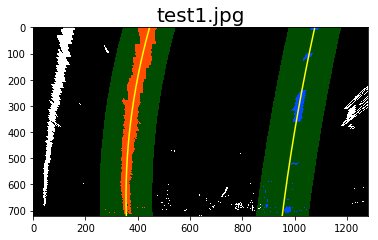

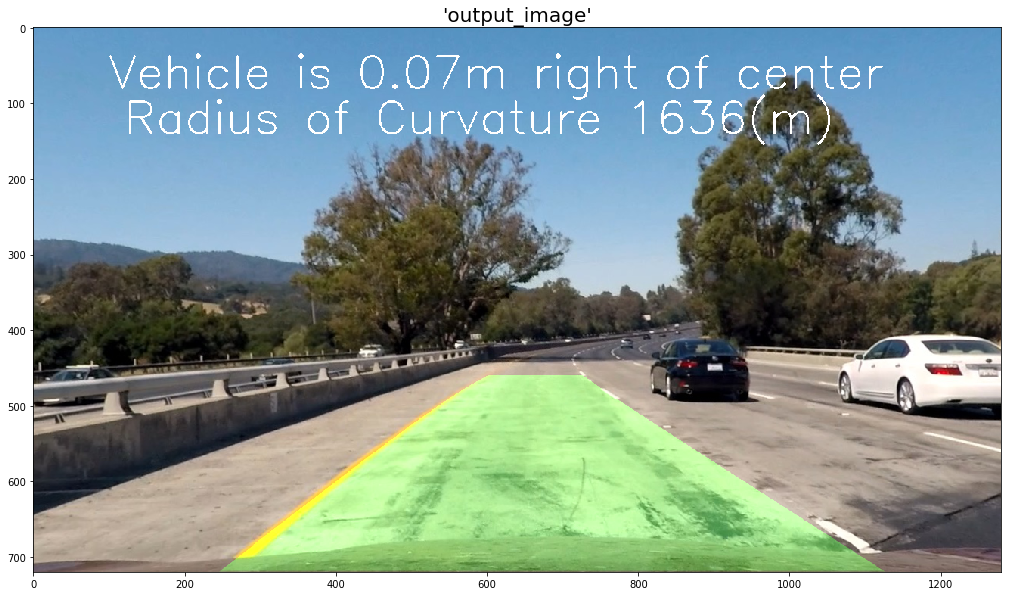

In [22]:
#OMNS
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os, glob
import cv2

%matplotlib inline

#######  Parameters/Controls ####################
DBG_PRINT_IMAGES = 3  # Display/Print the images
DBG_SAVE_IMAGES = 1   # Save the images
DBG_NUM_FRAMES = 2    # No. of frames to process

DBG_CALIBRATE_CAMERA_ON = False
calib_disp_file = 'calibration2.jpg'

DBG_PROCESS_IMAGES_ON = True # Run this function

USE_FIND_THRESHOLD_LAB = 1 # Use Lab space for threshold function
use_xgrad = 0
use_ref_srcp = 0 # "1" is golden Use reference src/dst points

img_folder='camera_cal/'

#################################################

### Function to plot images
def plot_images(img_list, cmap_gray, title_list, imgs_per_row=3, figsize=(24,9)):
    """
    Plot the images with given layout and number of images pr row
    And also save the images to the current folder
    """
    nrows = -(-len(img_list)//imgs_per_row) 
    ncols = imgs_per_row
    f, axes = plt.subplots(nrows, ncols, figsize=figsize)
    f.tight_layout()
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
    idx = 0
    for axis in axes.flatten():
        if cmap_gray[idx]==1:  axis.imshow(img_list[idx], cmap='gray')
        else: axis.imshow(img_list[idx])
        img_title ="'"+title_list[idx]+"'"
        axis.set_title(img_title, fontsize=20)
        idx=idx+1
    if (DBG_SAVE_IMAGES > 0):
        plt.savefig('Undistort.png')


### Camera Calibration
def Calibrate_Camera(img_folder='camera_cal/', nx=9, ny=6, fnum=calib_disp_file):
             
    """
    Calibrate camera to generate Transformation Matrix and Distortion Coeffs
    to be used to undistort images and perform transofrm before processing
    """
    print("Calibrate_Camera: Camera Calibration called")
    
    # Read in images to make a list
    images = glob.glob(img_folder+'*.jpg')
    #print(images)
    # For Test purpose
    disp_imglist=[]
    
    # Arrays to store Object points and Image points from all images
    objpoints = [] # 3D point in real world space
    imgpoints = [] # 2D point in image plane space
    
    # Prepare 3D object points like (0,0,0), (1,0,0), (2,0,0)...(8,5,0)
    # z-cord is always "0" as camera images are assumed to be flat surface
    objp = np.zeros((nx*ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2) # x,y co-ords
        
    # Calculate 2D image points from all the Calibration images
    for fname in images:
        img = mpimg.imread(fname)
        if fnum in fname:
            #print ("Appending orig", fnum)
            disp_imglist.append(img)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        
        # If corners found then append to the imagpoint list
        if ret==True:
            imgpoints.append(corners)
            objpoints.append(objp)
            
            # draw and display the corners for the image
            cimg = np.copy(img)
            cimg = cv2.drawChessboardCorners(cimg, (nx,ny), corners, ret)
            if fnum in fname:             
                #print ("Appending draw", fnum)
                disp_imglist.append(cimg)
    
    # calibrate camera using the image point and object points to get Camera Matrix and Distorion Coeffs
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    print ('mtx:', mtx)
    for fname in images:
        img = mpimg.imread(fname)
        dst = cv2.undistort(img, mtx, dist, None, mtx)
        if fnum in fname: 
            #print ("Appending undistort", fnum)
            disp_imglist.append(dst)
    return disp_imglist, mtx, dist
    
    
# Image folder containing Calibration Images
disp_imglist = []
# Calibrate Camera using the images in camera calibration folde
if DBG_CALIBRATE_CAMERA_ON == True:
    disp_imglist, camera_mtx, camera_dist = Calibrate_Camera(img_folder, nx=9, ny=6, fnum='n3.jpg')

    # Plot the Camera Calibration images
    cmap_gray=[0,0,0]
    title_list=['Original', 'Corners Detected', 'Undistorted']
    print (len(disp_imglist))
    plot_images(disp_imglist, cmap_gray, title_list)

print('*** Calib Done ***')

#########################################################################
#######  Parameters/Controls ############################################

### Image Size
default_image_size = (720, 1280)

camera_mtx = None
camera_dist = None

###  Threshold tuning Parameters
# Mask for Thresholding: Vertices for region of interest
msk_ll_wid = 0.13; msk_lr_wid = 0.92
msk_ul_wid = 0.45; msk_ur_wid = 0.54
msk_ur_hgt = 0.37    # % height of ROI from bottom of Image

sobel_ksize = 3
xgd_thresh = (20, 100)
ygd_thresh = (20, 100)
mag_thresh = (30, 100)
dir_thresh = (0.7, 1.3)
sat_thresh = (170, 255)
hue_thresh = (15, 100)
lum_thresh = (213, 255)
b_thresh   = (146, 201)

###  Warped Image tuning parameters
# Vertices for region of inter1st
roi_ll_wid = 0.15; roi_lr_wid = 0.89
roi_ul_wid = 0.45; roi_ur_wid = 0.55
roi_ur_hgt = 0.36                     # % height of ROI from bottom of Image

roi_dst_voffset = 0 # pixels
roi_dst_hoffset = 320 # pixels

### Finding Lines tuning parameters
# Set the width of the windows +/- margin
margin_window_width = 100
# Set minimum number of pixels found to recenter window
minpix_recenter_window = 50
### Find Radius of Curvature tuning parameters
#Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

if DBG_PROCESS_IMAGES_ON == True:
    disp, camera_mtx, camera_dist = Calibrate_Camera()

###################   Functions   #################################################
### Function to plot images
def plot_images(img_list, cmap_gray, title_list, imgs_per_row=2, figsize=(24,9),fname='savefig'):
    nrows = -(-len(img_list)//imgs_per_row) 
    ncols = imgs_per_row
    f, axes = plt.subplots(nrows, ncols, figsize=figsize)
    f.tight_layout()
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
    idx = 0
    if len(img_list) > 1: axes_array = axes.flatten()
    else: axes_array = [axes]
    for axis in axes_array:
        if cmap_gray[idx]==1:  axis.imshow(img_list[idx], cmap='gray')
        else: axis.imshow(img_list[idx])
        img_title ="'"+title_list[idx]+"'"
        axis.set_title(img_title, fontsize=20)
        idx=idx+1
    if (DBG_PRINT_IMAGES > 0):
        plt.savefig(fname)

def show_img (img):
    """
    Plot/Display the image
    """
    #print("Image is:", type (img), "Size: (WxH)", len(img.shape), img.shape[0], img.shape[1])
    if len(img.shape) == 2: 
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img)
         
  
### Create vertices for source ROI
def roi_src_edges(img_size = default_image_size,
                 roi_ll_wid = roi_ll_wid,
                 roi_lr_wid = roi_lr_wid,
                 roi_ul_wid = roi_ul_wid,
                 roi_ur_wid = roi_ur_wid,
                 roi_ur_hgt = 1.0 - roi_ur_hgt, # Changed so that height is calculated from bottom
                 voffset     = roi_dst_voffset,
                 hoffset     = roi_dst_hoffset,
                 use_ref_srcp = use_ref_srcp
                 ):
    """
    Create Source and Destimation points used in Prespective Transform based
    on the image ROI tuning parameters
    """
    
    ref_src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[0, 720]])
    ref_dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
           
    # Select the region of interest
    img_height = img_size[0]
    img_width  = img_size[1]
    #print("width", img_width, "height", img_height)
    roi_ll_x = int(roi_ll_wid * img_width)
    roi_ll_y = int(img_height)
    roi_lr_x = int(roi_lr_wid * img_width)
    roi_lr_y = roi_ll_y
    roi_ul_x = int(roi_ul_wid * img_width)
    roi_ul_y = int(roi_ur_hgt * img_height)
    roi_ur_x = int(roi_ur_wid * img_width)
    roi_ur_y = roi_ul_y
    ver_ll = (roi_ll_x, roi_ll_y)
    ver_ul = (roi_ul_x, roi_ul_y)
    ver_ur = (roi_ur_x, roi_ur_y)
    ver_lr = (roi_lr_x, roi_lr_y)
    
    #For Perspective Transform
    src = np.float32([ver_ul, ver_ur, ver_lr, ver_ll])
    
    dst = np.float32([[hoffset, voffset], [img_width-hoffset, voffset], 
                     [img_width-hoffset, img_height-voffset], [hoffset, img_height-voffset]])

     
    if use_ref_srcp==1: return ref_src, ref_dst
    else:  return src, dst


### Create Masked Image with ROI (Vertices)
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    
    # Create mask image with ROI and 
    msk_img = region_of_interest(edg_img, vertices)
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

### Create Binary Image based on Threshold 
def thresh_binary(img, scale_factor=255, thresh=(0,255)):
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    if (scale_factor==1): scaled_img = img
    else: scaled_img = np.uint8(scale_factor*img/np.max(img))
    
    th_binary = np.zeros_like(scaled_img)
    th_binary[(scaled_img >= thresh[0]) & (scaled_img <= thresh[1])] = 1
    return th_binary

### Create Binary Image based on Condition
def combined_binary(img, cond):
    comb_binary = np.zeros_like(img)
    comb_binary[cond] = 1
    return comb_binary

### Functions to calculate the Garadient, magnitude and direction gradients
def cal_grad_thresh(img, orient='x', sobel_ksize=sobel_ksize, grad_thresh=(0,255)):
    #1) Take the derivative in x or y given orient = 'x' or 'y'
    if (orient=='x'): 
        sobel_grad = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_ksize)
    else:
        sobel_grad = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_ksize)
        
    # 2) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel_grad)
    
    # Scale img to 255 and return Thresholded binary image
    gbinary = thresh_binary(abs_sobel, scale_factor=255, thresh=grad_thresh)
    return sobel_grad, gbinary


def cal_mag_thresh(sobelx, sobely, mag_thresh):
    # Calculate the magnitude 
    sobel_mag = np.add(np.square(sobelx), np.square(sobely))
    sobel_mag = np.sqrt(sobel_mag)
    
    # Scale img to 255 and return the thresholded image
    mbinary = thresh_binary(sobel_mag, scale_factor=255, thresh=mag_thresh)
    return mbinary

def cal_dir_thresh (sobelx, sobely, dir_thresh):
    # Calculate the magnitude 
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    sobel_dir = np.arctan2(abs_sobelx, abs_sobely)
    
    # Scale img to 1 and return the thresholded image
    dbinary = thresh_binary(sobel_dir, scale_factor=1, thresh=dir_thresh)
    return dbinary

### Thresholding based on Lab and x&y gradients
def find_threshold_lab(img, 
                   chose_xgrad = use_xgrad,
                   sobel_ksize = sobel_ksize, 
                   xgd_thresh  = xgd_thresh,
                   b_thresh    = b_thresh,
                   lum_thresh  = lum_thresh
                   ): 
    """
    Image Pipeline to generate binary mask image with edge pixels
    Thresholding based on Lab and 'x', 'y', 'Gradient Direction'
    """
    img = np.copy(img)
    
    # Calculate "L" and "b" binary thresholded images
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab).astype(np.float)
    luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV).astype(np.float) 
    b_channel = lab[:,:,2]
    l_channel = luv[:,:,0]
    
    # Calculate "L" & "b" channel threshold binary
    b_binary = thresh_binary(b_channel, scale_factor=1, thresh=b_thresh)
    l_binary = thresh_binary(l_channel, scale_factor=1, thresh=lum_thresh)
 
    if (chose_xgrad == 1):
        # Calculate the binaryies for Gradient Threshold in x & y directions, magnitude, & direction
        sobelx,  xgd_binary = cal_grad_thresh(l_channel, orient='x', sobel_ksize=sobel_ksize, grad_thresh=xgd_thresh)
        comb_binary = combined_binary(xgd_binary, ((xgd_binary == 1) | (l_binary == 1) | (b_binary == 1)))
    else:
        comb_binary = combined_binary(l_binary, ((l_binary == 1) | (b_binary == 1)))
    
    return None, None, comb_binary

### Thresholding based on HLS and x&y gradients
def find_threshold(img, 
                   sobel_ksize = sobel_ksize, 
                   xgd_thresh  = xgd_thresh,
                   ygd_thresh  = ygd_thresh,
                   mag_thresh  = mag_thresh,
                   dir_thresh  = dir_thresh,
                   sat_thresh  = sat_thresh, 
                   hue_thresh  = hue_thresh): 
    """
    Image Pipeline to generate binary mask image with edge pixels
    Thresholding based on Saturation/Hue and 'x', 'y', 'Gradient Direction'
    """
    img = np.copy(img)
        
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    h_channel = hls[:,:,0]
    
    # Calculate the binaryies for Gradient Threshold in x & y directions, magnitude, & direction
    sobelx,  xgd_binary = cal_grad_thresh(l_channel, orient='x', sobel_ksize=sobel_ksize, grad_thresh=xgd_thresh)
    sobely,  ygd_binary = cal_grad_thresh(l_channel, orient='y', sobel_ksize=sobel_ksize, grad_thresh=ygd_thresh)
    mag_binary = cal_mag_thresh(sobelx, sobely, mag_thresh=mag_thresh)
    dir_binary = cal_dir_thresh(sobelx, sobely, dir_thresh=dir_thresh)
    
    # Calculate "Saturation" & "Hue" channel threshold binary
    sat_binary = thresh_binary(s_channel, scale_factor=1, thresh=sat_thresh)
    hue_binary = thresh_binary(h_channel, scale_factor=1, thresh=hue_thresh)

    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack((np.zeros_like(xgd_binary), xgd_binary, sat_binary)) * 255
    color_binary[:,:,0] = 0.01 * 255
    
    # Combine the two binary thresholds ('S' Saturation & 'x' Gradient magnitude)
    comb_binarys = combined_binary(xgd_binary, ((xgd_binary == 1) | (sat_binary == 1)))
    
    # Combine the two binary thresholds ('H' Hue & 'x' Gradient magnitude)
    #combined_binaryh = np.zeros_like(sxbinary)
    #combined_binaryh[(h_binary == 1) | (sxbinary == 1)] = 1 # "H & x"
    comb_binaryh = combined_binary(xgd_binary, ((xgd_binary == 1) | (hue_binary == 1)))

    return color_binary, comb_binaryh, comb_binarys


### Unwarp Image
def corners_unwarp(img, src, dst):
    """ 
    Apply Perspective transofrm on the input images with given Source and
    Destination points
    """
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img.shape[1::-1], flags=cv2.INTER_LINEAR) 
    # Return the resulting image and matrix
    return Minv, M, warped

### Finding Lines in a Frame
def find_lines_frame(binary_warped, 
                     margin=margin_window_width, 
                     minpix=minpix_recenter_window):
    """
    Find lane lines in the given warped+thresholded binary image  using 
    BLIND search without any prior searh criteria and finding line points
    using histogram
    """
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    #out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        #(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        #(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
   
    return leftx, rightx, lefty, righty, left_lane_inds, right_lane_inds


### Finding Lines Using Previous Frame Data 
def find_lines_using_prev_frame(binary_warped, left_fit, right_fit,
                               margin=margin_window_width):
    """
    Use previous frame finding_lines search result to target the
    search for next frame
    """
    # Get x,y positions where pixels are non-zero (binary image)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Get Left and Right lane indices of the pixel positions within MARING WINDOW
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
        
    return leftx, rightx, lefty, righty, left_lane_inds, right_lane_inds
    
### Visualize Finding Lines result 
def plot_finding_lanes (fname, binary_warped,
                        leftx, rightx, lefty, righty,
                        left_fitx, right_fitx, ploty,
                        margin = margin_window_width,
                        fnumber = None,
                        plot_search_area=1):
    """
    Plot the lines in the given image using the x,y co-ordinates of the lines
    and also mark the x,y points used for fitting the lines
    """
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    if (plot_search_area == 1):    final_img = result
    else:                          final_img = out_img
    # Create a new plot everytime the function is called
    f = plt.figure()
    a= f.add_subplot(111); a.set_title(fname, fontsize=20)
    plt.imshow(final_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    if (DBG_SAVE_IMAGES > 1):
        filename = str(fnumber)+'_Draw_lines.png'
        plt.savefig(filename)
    return final_img

### Draw the 
def draw_lines (undist_img, 
                binary_warped, 
                Minv,
                left_fitx, 
                right_fitx, 
                ploty,
                offset = 0,
                offset_dir = 'left',
                roc_left = 0,
                roc_right = 0):
    
    """
    # warped binary image called warped
    # have fit the lines with a polynomial and have arrays
    # called ploty, left_fitx and right_fitx, which represent the x and y pixel values of the lines
    """
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (binary_warped.shape[1], binary_warped.shape[0])) 
    # Combine the result with the original image
    result_img = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
    
    # Add Radius of Curvature and Offset to Image
    cv2.putText(result_img, 'Vehicle is {:.2f}m {} of center'.format(offset, offset_dir), (100,80),
                 fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    cv2.putText(result_img, 'Radius of Curvature {}(m)'.format(int((roc_left + roc_right)/2)), (120,140),
             fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    
    
    return result_img


### Calculate Radius of Curvature
def calc_roc_offset (img_width, left_fit, right_fit, leftx, rightx, lefty, righty, 
                   ploty, ym_per_pix=ym_per_pix, xm_per_pix=xm_per_pix):
    
    y_eval = np.max(ploty) # At bottom of the image (y_eval = img_height)
    
    # Calculate Radius of Curvature in Image/pixel space 
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    print('roc in pixels:',left_curverad, right_curverad)
    
    # Fit new polynomials to x,y in world space
    # Fit a second order polynomial in real world space
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Radius of curvature is in meters
    print('roc in meters:',left_curverad, 'm',right_curverad, 'm')
    
    # Caluclate the Distance from center (offset)
    #print ('img_width:', img_width, ' left_xincpt:', left_fit_cr[2], ' right_xincpt:', right_fit_cr[2], )
    left_xint = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    right_xint = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    offset_pix = int(img_width/2 - (left_xint + right_xint)/2)
    offset_dir = 'left'
    if (offset_pix < 0): offset_dir = 'right'
    offset_real = abs(offset_pix) * xm_per_pix
    
    # Calculate slope of the lines at mid-point (slope = 2Ay + B)
    yslope = y_eval/2
    left_slope = 2*left_fit[0]*yslope+ left_fit[1]
    right_slope = 2*right_fit[0]*yslope+ right_fit[1]
    
    # Calculate the horizontal distance between the lines at mid-point
    yhdist = y_eval/2
    hor_dist = (right_fit[0]*yhdist**2 + right_fit[1]*yhdist + right_fit[2]) - \
               (left_fit[0]*yhdist**2 + left_fit[1]*yhdist + left_fit[2])
    
    #print(offset_real, 'm', offset_dir)   
    return offset_real, offset_dir, left_curverad, right_curverad


### Image process pipeline
def process_image (image,
                   fnum = None,
                   fname = None,
                   camera_mtx = camera_mtx,
                   camera_dist = camera_dist):
    """
    Process a given image for finding and drawing lines
    ### Step 0: Camera Calibration (Create Matrix & Distorting coefficents)
    ### For each Image
        Step 1: Undistort the Image
        Step 2: Thresholding (Create binary image)
        Step 3: Apply Perspective Transform
        Step 4: Find lines in the warped+thresholded binary image using 
                blind search/previous frame findings
        Step 5: Unwarp the image and Draw the lines (calc roc/offset)
    """
    
    # Apply Camera Matrix and Distortion Coeffs to undistort the image
    undist_img = cv2.undistort(image, camera_mtx, camera_dist, None, camera_mtx)

    # Apply Thresholding to detect the edges
    if USE_FIND_THRESHOLD_LAB == 1:
        none0, none1, sthresh_img = find_threshold_lab(undist_img, chose_xgrad=1)
    else:
        stacked, hthresh_img, sthresh_img = find_threshold(undist_img)
     
    # Plotting the Threshold Images
    #img_list = [image, stacked, resulth, results]
    #cmap_gray = [0,0,1,1]
    #title_list = [file,, 'Hue gradient', 'Saturation Gradient']
    #plot_images(img_list, cmap_gray, title_list)
    print ('*** Frame Number: ', fnum)
    
    # Plotting Undistort and Threshold Images
    if (DBG_PRINT_IMAGES > 0):
        # Plot Undistorted Image
        img_list = [image, undist_img]
        cmap_gray = [0,0]
        title_list = [file,'Undistorted Image']
        plot_images(img_list, cmap_gray, title_list, fname=str(fnumber)+'_Undistorted_Image.png')
        # Plot Threshold Image
        img_list = [undist_img, sthresh_img]
        cmap_gray = [0,1]
        title_list = ['Undistorted Image','Threshold Image']
        plot_images(img_list, cmap_gray, title_list, fname=str(fnumber)+'_Threshold_Image.png')
    
    # Apply Perspective Transform to unwarp the image
    img_width, img_height = (sthresh_img.shape[1], sthresh_img.shape[0])
    srcp, dstp = roi_src_edges ((img_height, img_width))
    # Print src/dst
    if (fnumber == 1):
        print('Src Points: ', srcp)
        print('Dst Points: ', dstp)
    Minv1, M1, undist_warped = corners_unwarp(undist_img, srcp, dstp)
    Minv, M, binary_warped = corners_unwarp(sthresh_img, srcp, dstp)
    #----Plotting the Warped Images
    if DBG_PRINT_IMAGES > 1:
        # Draw ROI on undistorted Image
        vertsrc = np.array([srcp], dtype=np.int32)
        vertdst = np.array([dstp], dtype=np.int32)
        roi_undist = cv2.polylines (np.copy(undist_img), [vertsrc], True, [255,0,0], 10 )
        roi_warped = cv2.polylines (np.copy(undist_warped), [vertdst], True, [255,0,0], 10 )
        img_list = [roi_undist, roi_warped]
        cmap_gray = [0,0]
        title_list = ['ROI_Undistored', 'ROI_Warped']
        plot_images(img_list, cmap_gray, title_list,fname=str(fnumber)+'_ROI_Warped.png')
    #break
   
    # Find lines in the Threshold Image 
    leftx, rightx, lefty, righty, left_lane_inds, right_lane_inds = find_lines_frame(binary_warped)
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Calculate Radius of Curvature (roc)
    roc_left = 0; roc_right = 0
    offset, offset_dir, roc_left, roc_right = calc_roc_offset (binary_warped.shape[1], 
                                                               left_fit, right_fit, 
                                                               leftx, rightx, lefty, righty, ploty)
    #----Plotting find_lines Images
    if DBG_PRINT_IMAGES > 2:
        find_line_img = np.copy(binary_warped)
        plot_finding_lanes (fname, find_line_img,leftx,rightx,lefty,righty,left_fitx,right_fitx,ploty); 
    
    #----Assemble/Visualize final image with lane markings and polyfill
    #find_line_img = np.copy(binary_warped)
    result_img = draw_lines(undist_img, binary_warped, Minv, left_fitx, \
                        right_fitx, ploty, offset, offset_dir, roc_left, roc_right)
    
    if DBG_PRINT_IMAGES > 2:
        img_list = [result_img]
        cmap_gray = [0]
        title_list = ['output_image']
        plot_images(img_list, cmap_gray, title_list,imgs_per_row=1,fname=str(fnumber)+'_output_image.png')
    
    return undist_img, result_img
    #return result
    
################### Read/Process the images ###########################
fnumber = 0
if DBG_PROCESS_IMAGES_ON == True:
    for file in os.listdir("test_images"):
        # Read the image
        image = mpimg.imread(os.path.join('test_images', file))
        fnumber = fnumber + 1
        undist, result = process_image(image, fnum=fnumber,fname=file)
    
        #Plotting the Warped Images
        img_list = [np.copy(undist), np.copy(result)]
        cmap_gray = [0,1]
        title_list = [file +' - ROI_Undistored', file + ' - Undistored Warped']
        #plot_images(img_list, cmap_gray, title_list)
    
        #plt.imshow(result_image)
        if fnumber > DBG_NUM_FRAMES: 
            break
        
print ("***Done***")  



In [15]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from collections import deque
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
#import os, glob
import cv2

%matplotlib inline

########################################################
#########  Params/Controls  #######################

DBG_FORCE_BLIND_SEARCH = False
DBG_PRINT = 0

# Find lines in the Thresholded, binary, warped Image 
margin = 100; minpix = 50; 
min_frame_count = 5

# Sanity check params
roc_tolerance = 0.5
slope_tolerance = 0.5
hdist_tolerance = 0.2

line_center_pix = 640  # Lane center in pixels
hdist_pix = 900        # Expected separation distance in pixels

yval_offset = 719      # Measure offset at yval_offset (line_base_pos)
yval_roc = 719         # Measure roc at yval_roc
yval_slope = 720/2     # Measure slope at yval_slope
yval_hdist = 720/2     # Measure Separation distance at yval_hdist


#######################################################

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line (****)
        self.recent_xfitted = deque(maxlen=min_frame_count)   
        #average x values of the fitted line over the last n iterations (****)
        self.bestx = None     
        #polynomial coefficients for the most recent fit (****)
        self.current_fit = deque(maxlen=min_frame_count)  
        #polynomial coefficients averaged over the last n iterations (****)
        self.best_fit = None
        #radius of curvature of the line in some units
        self.roc = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #number of frames where lines went undetected in a row
        self.num_frames_missing = 0
        
    def flines_prev (self, line_fit, binary_warped, margin):
        """
        Use previous frame finding_lines search result to target the
        search for next frame
        """
        if (DBG_PRINT ==1): print ('Func: flines_prev called')
        # Get x,y positions where pixels are non-zero (binary image)
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Get lane indices of the pixel positions within MARING WINDOW
        lane_inds = ((nonzerox > (line_fit[0]*(nonzeroy**2) + line_fit[1]*nonzeroy + 
        line_fit[2] - margin)) & (nonzerox < (line_fit[0]*(nonzeroy**2) + 
        line_fit[1]*nonzeroy + line_fit[2] + margin))) 

        # Again, extract left and right line pixel positions
        allx = nonzerox[lane_inds]
        ally = nonzeroy[lane_inds] 
    
        if (np.sum(allx)> 0): 
            self.detected = True 
            self.num_frames_missing =- 1
            self.allx = allx
            self.ally = ally
            self.roc = self.calc_roc(self.allx, self.ally)

        else: 
            self.detected = False
            self.num_frames_missing =+ 1
            
        return allx, ally


    def flines_blind (self, binary_warped, margin, minpix):
        if (DBG_PRINT ==1): print ('Func: flines_blind called')
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        if self == Left_Line:
            x_base = np.argmax(histogram[:midpoint])
        else:
            x_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
    
        # Current positions to be updated for each window
        x_current = x_base
        # Create empty lists to receive pixel indices
        lane_inds = []
  
        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_x_low = x_current - margin
            win_x_high = x_current + margin
            # Identify the nonzero pixels in x and y within the window
            good_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_x_low) &  (nonzerox < win_x_high)).nonzero()[0]
            # Append these indices to the lists
            lane_inds.append(good_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_inds) > minpix:
                x_current = np.int(np.mean(nonzerox[good_inds]))

        # Concatenate the arrays of indices
        lane_inds = np.concatenate(lane_inds)

        # Extract left and right line pixel positions
        allx = nonzerox[lane_inds]
        ally = nonzeroy[lane_inds] 
   
        if (np.sum(allx)> 0): 
            self.detected = True 
            self.num_frames_missing = 0
            self.allx = allx; self.ally = ally
            self.roc = self.calc_roc(self.allx, self.ally)
        else: 
            self.detected = False
            self.num_frames_missing =+ 1
            
        return allx, ally
    
    
    def calc_roc(self, allx, ally, yval=yval_roc, line_center=line_center_pix, ym_per_pix=ym_per_pix, xm_per_pix=xm_per_pix):
        # Fit a second order polynomial in real world space
        fit_cr = np.polyfit(ally*ym_per_pix, allx*xm_per_pix, 2)
        
        # Calculate the new radii of curvature (in METERS)
        roc = ((1 + (2*fit_cr[0]*yval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    
        #print('roc:', roc, 'm')
        return roc
    
    def calc_offset(self, line_fit, yval=yval_offset, line_center=line_center_pix, xm_per_pix=xm_per_pix):
        # Fit a second order polynomial in real world space
        x_intercept = line_fit[0]*yval**2 + line_fit[1]*yval + line_fit[2]
        
        # Caluclate the Distance from center (offset)
    
        #print('offset:', offset, 'pixels')
        return x_intercept


  
class Camera_Params():
    def __init__(self, calib_folder, img_size):
        self.calib_folder = calib_folder
        self.camera_mtx = None
        self.camera_dist = None
        self.img_size = img_size
        self.srcp = None
        self.dstp = None
        self.vertices = None
        self.num_frames = 0
        self.set_Camera_Params()
        self.dbg_print = 0
        
    def set_Camera_Params(self):
        disp,self.camera_mtx, self.camera_dist = Calibrate_Camera(self.calib_folder)
        self.srcp, self.dstp = roi_src_edges(self.img_size)
        

def Sanity_Check (Left_Line, Right_Line, 
                  yroc=yval_roc, roc_tolerance=roc_tolerance,
                  yslope=yval_slope, slope_tolerance=slope_tolerance,
                  yhdist=yval_hdist, hdist_value=hdist_pix, hdist_tolerance=hdist_tolerance, dbg_print=DBG_PRINT):
    # Set the flags
    is_roc_ok = False
    is_slope_ok = False
    is_hdist_ok = False
    
    # Fit polynomials
    left_fit = np.polyfit(Left_Line.ally, Left_Line.allx, 2)
    right_fit = np.polyfit(Right_Line.ally, Right_Line.allx, 2)
    
    # ROC check: to have similar radius of curvature (in pixels)
    left_roc = ((1 + (2*left_fit[0]*yroc + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_roc = ((1 + (2*right_fit[0]*yroc + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    tol_val = left_roc
    if (left_roc > right_roc): tol_val = right_roc
    if (abs(left_roc - right_roc) <= (tol_val * roc_tolerance)): is_roc_ok = True
        
    # Parallelism check: Slope at mid-point (slope = 2Ay + B))
    left_slope = 2*left_fit[0]*yslope+ left_fit[1]
    right_slope = 2*right_fit[0]*yslope+ right_fit[1]
    tol_val = left_slope
    if (left_slope > right_slope): tol_val = right_slope
    #if (left_slope <)
    if (abs(left_slope - right_slope) <= (tol_val * slope_tolerance)): is_slope_ok = True
        
    # Separation check: Horizontal distance between the lines at mid-point
    left_hx = (left_fit[0]*yhdist**2 + left_fit[1]*yhdist + left_fit[2])
    right_hx = (right_fit[0]*yhdist**2 + right_fit[1]*yhdist + right_fit[2]) 
    hor_dist = right_hx - left_hx
    if (hor_dist >= (hdist_value * (1.0-hdist_tolerance)) and \
        hor_dist <= (hdist_value * (1.0+hdist_tolerance))): is_hdist_ok = True

    if dbg_print == 1:
        print ('ROC: L:',left_roc, 'R:', right_roc)
        print ('Slope: L:',left_slope, 'R:', right_slope)
        print ('Hdistance: L:',left_hx, 'R:', right_hx)
        print ('Sanity_Check:', is_roc_ok, is_slope_ok, is_hdist_ok)
    
    return (is_roc_ok & is_slope_ok & is_hdist_ok), left_fit, right_fit

def Sanity_Check_Par (Left_Line, Right_Line, 
                      yval = (0,720/2,719),
                      hdist_value=hdist_pix,
                      hdist_tolerance=hdist_tolerance, 
                      dbg_print=DBG_PRINT):
    """ 
    Check if (2) given lines are parallel by measuring the horizontal
    distance between the two lines at all the given points(yval) and 
    compare it expected hor. distance with some tolerance
    """
    
    # Set the flags
    is_top_ok = False
    is_mid_ok = False
    is_bot_ok = False
    
    # Fit polynomials
    left_fit = np.polyfit(Left_Line.ally, Left_Line.allx, 2)
    right_fit = np.polyfit(Right_Line.ally, Right_Line.allx, 2)
    
    # Separation check: Horizontal distance between the lines at mid-point
    hor_dist = np.zeros_like(yval)
    is_hdist_ok = []
    for i in range(len(yval)):
        left_hx = (left_fit[0]*yval[i]**2 + left_fit[1]*yval[i] + left_fit[2])
        right_hx = (right_fit[0]*yval[i]**2 + right_fit[1]*yval[i] + right_fit[2])
        hor_dist[i] = right_hx - left_hx
    
        if (hor_dist[i] >= (hdist_value * (1.0-hdist_tolerance)) and \
            hor_dist[i] <= (hdist_value * (1.0+hdist_tolerance))): 
            is_hdist_ok.append(True)

    if dbg_print == 1:
        for i in range(len(yval)):
            print ('Sep Distance: L:',hor_dist[i])
        
    return (all(is_hdist_ok)), left_fit, right_fit

def dbg_pause():
    x = input("Paused for debug: Press Enter 0 to stop printing:")
    return x

#################### START: Process Video ###############################################

# Define Line clasee object for left/right lanes
Left_Line = Line();  Right_Line = Line()

# Initialize Camera Parameters (Calibrate camera, set image size)
CAMP = Camera_Params('camera_cal/', (720,1280))
#print (CAMP.camera_mtx)
CAMP.dbg_print = DBG_PRINT
def process_video (image):
    """
    Process each image of the video, consider using previous frame
    search findings for line search in current frame
    """
    
    # Debug statements
    CAMP.num_frames = CAMP.num_frames + 1
    DBG_PRINT = CAMP.dbg_print
    #if CAMP.dbg_print==1:
        #CAMP.dbg_print = dbg_pause()
    
    #print("frame #:", CAMP.num_frames)
    img_size = (image.shape[1], image.shape[0]) # width, height
    
    # Apply Camera Matrix and Distortion Coeffs to undistort the image
    undist_img = cv2.undistort(image, CAMP.camera_mtx, CAMP.camera_dist, None, CAMP.camera_mtx)
    
    # Apply Thresholding to detect the edges
    stacked, hthresh_img, sthresh_img = find_threshold_lab(undist_img)
    
    # Apply Perspective Transform to unwarp the image
    Minv, M, binary_warped = corners_unwarp(sthresh_img, CAMP.srcp, CAMP.dstp)
    
    
    # Debug purpose
    if DBG_FORCE_BLIND_SEARCH == True:
        Left_Line.detected = False
        Right_Line.detected = False  
         
    # Find lines using previous frame search values
    if Left_Line.detected == True and CAMP.num_frames > min_frame_count: # or Left_Line.num_frames_missing < missing_frames_threshold:
        leftx, lefty = Left_Line.flines_prev(Left_Line.best_fit, binary_warped, margin)
    if Right_Line.detected == True and CAMP.num_frames > min_frame_count: #or Right_Line.num_frames_missing < missing_frames_threshold:
        rightx, righty = Right_Line.flines_prev(Right_Line.best_fit, binary_warped, margin)
    
    # Find lines in current frame (blind search)                
    if Left_Line.detected == False or CAMP.num_frames <= min_frame_count:
        leftx, lefty = Left_Line.flines_blind(binary_warped, margin, minpix)
    if Right_Line.detected == False or CAMP.num_frames <= min_frame_count:
        rightx, righty = Right_Line.flines_blind(binary_warped, margin, minpix)

         
    if DBG_FORCE_BLIND_SEARCH == True:
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        Left_Line.line_base_pos = Left_Line.calc_offset(left_fit)
        Right_Line.line_base_pos = Right_Line.calc_offset(right_fit)
    else:
        # Sanity check
        valid_lines_detected = False
        if Left_Line.detected == True and Right_Line.detected == True:
            #valid_lines_detected, left_fit, right_fit = Sanity_Check(Left_Line, Right_Line)
            valid_lines_detected, left_fit, right_fit = Sanity_Check_Par(Left_Line, Right_Line)
            if CAMP.dbg_print == 1:
                print ('Frame {}, Sanity Check output: {}'.format(CAMP.num_frames, valid_lines_detected))
            
        # Store current params if valid lines detected or first few frames
        if valid_lines_detected == True:
            # left_fit, right_fit from Sanity_Check output
                    
            # Generate x and y values for plotting
            ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
                
            # Update the Line Parameters
            # x values of the last n fits of the line
            Left_Line.recent_xfitted.append(left_fitx)  
            Right_Line.recent_xfitted.append(right_fitx) 
                
            # average x values of the fitted line over the last n iterations
            Left_Line.bestx = np.mean(Left_Line.recent_xfitted, axis=0)    
            Right_Line.bestx = np.mean(Right_Line.recent_xfitted, axis=0)    
                
            # polynomial coefficients for the most recent fit
            Left_Line.current_fit.append(left_fit)
            Right_Line.current_fit.append(right_fit)
        
            # polynomial coefficients averaged over the last n iterations
            Left_Line.best_fit = np.mean(Left_Line.current_fit, axis=0)
            Right_Line.best_fit = np.mean(Right_Line.current_fit, axis=0) 
        
        # Calculate Line offset from center of lane
        Left_Line.line_base_pos = Left_Line.calc_offset(Left_Line.best_fit)
        Right_Line.line_base_pos = Right_Line.calc_offset(Right_Line.best_fit)
    
        # Update the Line parameters if Lines are detected and valid
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = Left_Line.best_fit[0]*ploty**2 + Left_Line.best_fit[1]*ploty + Left_Line.best_fit[2]
        right_fitx = Right_Line.best_fit[0]*ploty**2 + Right_Line.best_fit[1]*ploty + Right_Line.best_fit[2]
    
        
    # Finally calculate ROC and Offset to plot/Visualize the image
    # Calculate roc/offset (distance from center of the lane)
    roc_left = Left_Line.roc; roc_right = Right_Line.roc
    #print ("roc:", roc_left, roc_right)
    offset = (image.shape[1]/2) - (Left_Line.line_base_pos + Right_Line.line_base_pos)/2
    offset = offset * xm_per_pix
    if (offset < 0): offset_dir = 'right'
    else: offset_dir = 'left'
    offset = abs(offset)
    
    #----Assemble/Visualize final image with lane markings and polyfill
    #find_line_img = np.copy(binary_warped)
    result_img = draw_lines(undist_img, binary_warped, Minv, Left_Line.bestx, 
                        Right_Line.bestx, ploty, offset, offset_dir, roc_left, roc_right)
    
    #plt.show(result_img)
    return result_img


# For Test purpose
def do_nothing(image):
    return image

# Read in the VideoFile and process each image.
#video = 'project'
video = 'challenge'
in_video = 'test_videos/' + video + '_video.mp4'
video_output = 'test_videos_output/out_' + video + '_video.mp4'
#video_output = 'test_videos_output/out_project_video.mp4'
#clip1 = VideoFileClip("test_videos/project_video.mp4").subclip(0,5)
#clip1 = VideoFileClip("test_videos/project_video.mp4").subclip(20,25)
#clip1 = VideoFileClip("test_videos/project_video.mp4")
#clip1 = VideoFileClip("test_videos/callenge_video.mp4")
clip1 = VideoFileClip(in_video)
#project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
project_clip = clip1.fl_image(process_video) #NOTE: this function expects color images!!

%time project_clip.write_videofile(video_output, audio=False)





Calibrate_Camera: Camera Calibration called
mtx: [[  1.15158804e+03   0.00000000e+00   6.66167057e+02]
 [  0.00000000e+00   1.14506859e+03   3.86440204e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
[MoviePy] >>>> Building video test_videos_output/out_challenge_video.mp4
[MoviePy] Writing video test_videos_output/out_challenge_video.mp4


100%|████████████████████████████████████████| 485/485 [01:35<00:00,  4.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/out_challenge_video.mp4 

Wall time: 1min 36s


In [6]:
import numpy as np
from collections import deque

s = np.array([1,2,3])
t = np.array([8,8,8])

a = deque(maxlen=4)

for i in range (4):
    if (i%2 ==0):  a.append(s)
    if (i%2 ==1):  a.append(t)
    print(i, a)

#print(a)

print (np.sum(a, axis=0))

print (np.mean(a, axis=0))


h = []
h.append = True

print (h, any(h))

SyntaxError: invalid syntax (<ipython-input-6-7f7a4ce8d743>, line 24)

In [12]:
str1 = 'hello'
fnum= 2
print(str(fnum)+str1)

2hello
